In [17]:
import numpy as np

import astropy.units as u
from astropy.constants import c
from astropy.coordinates import get_body, SkyCoord, HeliocentricMeanEcliptic, HeliocentricEclipticIAU76
from astropy.time import Time


import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from IPython.core.display import display, HTML
from tqdm.notebook import tqdm

from astroquery.jplhorizons import Horizons

display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib notebook

In [15]:
perseverance_data = Horizons(id='-168', id_type='id', epochs={
    'start':'2020-07-30T13:00:00',
    'stop':'2021-03-10',
    'step':'1d',
}).ephemerides()



In [21]:
perseverance_data

<Table masked=True length=223>
         targetname             datetime_str   ...  PABLon   PABLat
            ---                     ---        ...   deg      deg  
           str28                   str17       ... float64  float64
---------------------------- ----------------- ... -------- -------
Mars2020 (spacecraft) (-168) 2020-Jul-30 13:00 ... 309.2384   8.161
Mars2020 (spacecraft) (-168) 2020-Jul-31 13:00 ... 340.8638 11.0236
Mars2020 (spacecraft) (-168) 2020-Aug-01 13:00 ... 342.0914 10.9435
Mars2020 (spacecraft) (-168) 2020-Aug-02 13:00 ... 342.8919 10.8852
Mars2020 (spacecraft) (-168) 2020-Aug-03 13:00 ...  343.571 10.8346
Mars2020 (spacecraft) (-168) 2020-Aug-04 13:00 ... 344.1963  10.788
Mars2020 (spacecraft) (-168) 2020-Aug-05 13:00 ...  344.791 10.7438
Mars2020 (spacecraft) (-168) 2020-Aug-06 13:00 ... 345.3657 10.7012
Mars2020 (spacecraft) (-168) 2020-Aug-07 13:00 ... 345.9253 10.6598
                         ...               ... ...      ...     ...
Mars2020 (spacecraft) (-168) 2021-Feb-28 13:00 ...  76.4893  1.4601
Mars2020 (spacecraft) (-168) 2021-Mar-01 13:00 ...  77.0192   1.467
Mars2020 (spacecraft) (-168) 2021-Mar-02 13:00 ...  77.5493  1.4738
Mars2020 (spacecraft) (-168) 2021-Mar-03 13:00 ...  78.0794  1.4804
Mars2020 (spacecraft) (-168) 2021-Mar-04 13:00 ...  78.6097  1.4868
Mars2020 (spacecraft) (-168) 2021-Mar-05 13:00 ...  79.1402  1.4931
Mars2020 (spacecraft) (-168) 2021-Mar-06 13:00 ...  79.6707  1.4993
Mars2020 (spacecraft) (-168) 2021-Mar-07 13:00 ...  80.2014  1.5054
Mars2020 (spacecraft) (-168) 2021-Mar-08 13:00 ...  80.7322  1.5113
Mars2020 (spacecraft) (-168) 2021-Mar-09 13:00 ...  81.2632  1.5171

In [28]:
t = Time(perseverance_data['datetime_jd'], format='jd')

perseverance_coords = SkyCoord(
    lat=perseverance_data['EclLat'].quantity,
    lon=perseverance_data['EclLon'].quantity,
    distance=perseverance_data['r'].quantity,
    frame=HeliocentricMeanEcliptic(obstime=t)
).transform_to(HeliocentricMeanEcliptic())

In [38]:
# Get Earth and Mars positions in the Ecliptic.
# Heliocentric to have the sun at 0,0 of the cartesian representation.

earth = get_body('Earth', t).transform_to(HeliocentricMeanEcliptic(obstime=t))
mars = get_body('Mars', t).transform_to(HeliocentricMeanEcliptic(obstime=t))

# get the cartesian representation. Defauls is spherical.
earth_cart = earth.cartesian
mars_cart = mars.cartesian
perseverance_cart = perseverance_coords.cartesian

earth_x = earth_cart.x.to_value(u.AU)
earth_y = earth_cart.y.to_value(u.AU)
mars_x = mars_cart.x.to_value(u.AU)
mars_y = mars_cart.y.to_value(u.AU)


# calculate distance and signal delay
distance = earth.separation_3d(mars)
signal_delay = (distance / c).to(u.min)

<IPython.core.display.Javascript object>


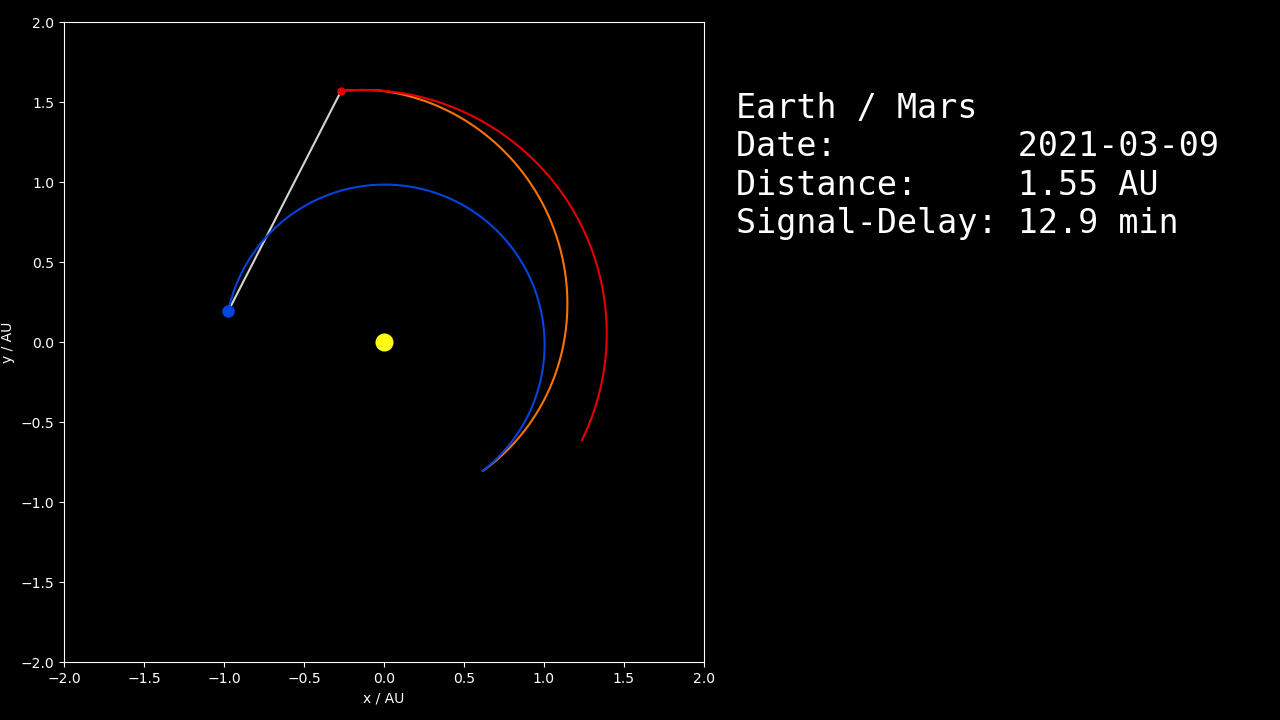

  0%|          | 0/224 [00:00<?, ?it/s]

In [40]:
plt.style.use('dark_background')

fig = plt.figure(figsize=(12.8, 7.2), dpi=100)
ax = fig.add_axes([0.05, 0.05, 0.5, 0.95])
ax.set_aspect(1)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_xlabel('x / AU')
ax.set_ylabel('y / AU')

plot_perseverance_line, = ax.plot([], [], color='xkcd:orange')
plot_perseverance_dot, = ax.plot([], [], marker='o', ms=4, color='xkcd:orange')

plot_distance, = ax.plot([], [], color='lightgray')
plot_earth, = ax.plot([], [], color='xkcd:blue', marker='o', ms=8)
plot_mars, = ax.plot([], [], color='xkcd:red', marker='o', ms=5)

plot_earth_line, = ax.plot([], [], color='xkcd:blue')
plot_mars_line, = ax.plot([], [], color='xkcd:red')


plot_sun, = ax.plot(0, 0, color='xkcd:yellow', marker='o', ms=12)



text_template = '''
Earth / Mars
Date:         {t:%Y-%m-%d}
Distance:     {distance:4.2f} AU
Signal-Delay: {delay:4.1f} min
'''

text = ax.text(1.05, 0.95, text_template, ha='left', va='top', transform=ax.transAxes, family='monospace', size=24)

bar = tqdm(total=len(t) + 1)

def update(frame):
    bar.update(1)

    
    
    
    plot_perseverance_line.set_data(perseverance_cart.x[:frame].to_value(u.AU), perseverance_cart.y[:frame].to_value(u.AU))
    plot_perseverance_dot.set_data(perseverance_cart.x[frame].to_value(u.AU), perseverance_cart.y[frame].to_value(u.AU))
    
    plot_earth.set_data(earth_x[frame], earth_y[frame])
    plot_earth_line.set_data(earth_x[:frame], earth_y[:frame])
    plot_mars.set_data(mars_x[frame], mars_y[frame])
    plot_mars_line.set_data(mars_x[:frame], mars_y[:frame])
    
    plot_distance.set_data([earth_x[frame], mars_x[frame]], [earth_y[frame], mars_y[frame]])

    text.set_text(text_template.format(t=t[frame].to_datetime(), distance=distance[frame].to_value(u.AU), delay=signal_delay[frame].to_value(u.min)))
    
    return plot_earth, plot_mars, plot_distance, text


ani = FuncAnimation(fig, update, frames=len(t), interval=1000/50, repeat=False)
ani.save('mars.mp4', extra_args=['-pix_fmt', 'yuv420p'], bitrate=-1)